# Prelim

## Imports

*  "C1" = Cluster 1
*  "CP" = Cluster Prime Parameter
*  "FGM" = Flux Gate Magnetometer
*  "5VPS" = 5 vectors/second resolution
*  Skeleton table: https://spdf.gsfc.nasa.gov/pub/software/cdawlib/0SKELTABLES/c1_cp_fgm_5vps_00000000_v01.skt

In [4]:
"""
import sys
!{sys.executable} -m pip install cdflib
"""

'\nimport sys\n!{sys.executable} -m pip install cdflib\n'

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from time import strftime, localtime
from datetime import datetime
import pandas as pd

import os
import cdflib

In [6]:
# Specify your directory containing the CDF files
cdf_directory = '2020_Feb_Cluster/'

# Define the date range
start_date = datetime(2020, 1, 1)
end_date = datetime(2020, 1, 7)

start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

R_E = 6370 # Cluster takes 1 earth radius to be 6370 km

In [7]:
def open_cdfs_in_date_range(directory, start_date, end_date):
    """
    Filters cdf files in a given directory based on a specified date range.

    Parameters
    ----------
    directory : str
        The path to the directory containing the cdf files.
        
    start_date : datetime
        The starting date of the range for which files should be selected.
        
    end_date : datetime
        The ending date of the range for which files should be selected.

    Returns
    -------
    list of str :
        A list of file paths for cdf files whose dates fall within the specified range.
    """
    cdf_files = []
    for file in os.listdir(directory):
        if file.endswith('.cdf'):
            # Assuming filename is data-name__dates_version.cdf
            date_str = file.split('__')[1][:8]  # Get the first 8 characters after '__' (YYYYMMDD)
            file_date = datetime.strptime(date_str, '%Y%m%d')
            
            # Check if file_date is within the date range
            if start_date <= file_date <= end_date:
                cdf_files.append(os.path.join(cdf_directory, file))
    
    return cdf_files

In [8]:
def load_cdf_data(cdf_file, variables):
    """
    Loads specified variables from a CDF file and returns a dictionary with extracted data.

    Parameters
    ----------
    cdf_file : str
        The path to the CDF file.
        
    variables : dict
        Dictionary where keys are the variable names to be used in the dataframe, 
        and values are the variable codes used to extract data from the CDF file.

    Returns
    -------
    dict :
        A dictionary where keys are variable names, and values are the corresponding data arrays.
    """
    # Load the CDF file
    cdf = cdflib.CDF(cdf_file)
    
    # Initialise a dictionary to store the data
    data_dict = {}
    
    # Loop through the dictionary of variables and extract data
    for var_name, var_code in variables.items():
        data = cdf.varget(var_code)  # Extract the data using the CDF variable code
        
        # Handle vector data
        if data.ndim == 2:  # Assuming a 2D array for vector components (e.g. Nx3 for 3D vectors)
            # Split into components (e.g. x, y, z)
            data_dict[f'{var_name}_x'] = data[:, 0]
            data_dict[f'{var_name}_y'] = data[:, 1]
            data_dict[f'{var_name}_z'] = data[:, 2]
            # Calculate the magnitude of the vector
            data_dict[f'{var_name}_mag'] = np.linalg.norm(data, axis=1)
        # Sclar data
        else:
            if var_name == "t":
                # Concerts epoch time (since 0 CE) into 'datetime'
                data = cdflib.cdfepoch.to_datetime(data)
            # Store the data in the dictionary with the desired variable name
            data_dict[var_name] = data
    
    return data_dict

In [9]:
def process_cdf_files(cdf_files, variables):
    """
    Processes a list of CDF files and extracts the specified variables, returning a pandas DataFrame.

    Parameters
    ----------
    cdf_files : list of str
        List of paths to the CDF files to be processed.
        
    variables : dict
        Dictionary where keys are the variable names to be used in the dataframe, 
        and values are the variable codes used to extract data from the CDF file.

    Returns
    -------
    pandas.DataFrame : one column for each variable :
        A DataFrame containing the extracted data from the CDF files, with scalar variables as columns,
        vector components as separate columns, and the magnitude of vectors.
    """
    # Initialise an empty DataFrame
    df = pd.DataFrame()

    # Loop through each CDF file and extract data
    for cdf_file in cdf_files:
        
        # Load the data for the specified variables
        data_dict = load_cdf_data(cdf_file, variables)

        try:
            # Convert the data_dict to a DataFrame for this file
            file_df = pd.DataFrame(data_dict)
            
            # Append the file's DataFrame to the main DataFrame
            df = pd.concat([df, file_df], ignore_index=True)
            
        except ValueError as ve:
            print(data_dict)
            
    return df

In [10]:
def segment_dataframe(df, column='t', delta='200ms'):
    """
    Adds a 'segment' column to the DataFrame based on time gaps exceeding a threshold, (for plotting purposes).
    
    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame containing data to be segmented.
    column : str
        The name of the column with time values.
    delta : str or pd.Timedelta
        The time gap threshold for segmenting data.

    Returns
    -------
        None - the procedure modifies the input DataFrame in place.
    """

    # Ensure delta is a Timedelta object
    time_threshold = pd.Timedelta(delta)
    
    # Calculate the time differences between consecutive rows
    time_diffs = df[column].diff()

    # Create the 'segment' column in a single operation
    df.insert(0, 'segment', (time_diffs > time_threshold).cumsum())

## Extract Data

In [12]:
# List of paths to the files within the desired date range
cdf_files = open_cdfs_in_date_range(cdf_directory, start_date, end_date)

In [13]:
variables = {
    "t" : "time_tags__C1_CP_FGM_5VPS",     # extracts the epoch time in milliseconds (scalar).
    "B" : "B_vec_xyz_gse__C1_CP_FGM_5VPS", # extracts the fgm data in nT (vector).
    "r" : "sc_pos_xyz_gse__C1_CP_FGM_5VPS" # extracts the position in km from centre of Earth (vector).
}

In [14]:
# Process the CDF files and extract the data into a pandas DataFrame
df_fgm = process_cdf_files(cdf_files, variables)

In [15]:
# Display the first/last few rows of the DataFrame
print(df_fgm.head())
print(df_fgm.tail())

                        t    B_x     B_y    B_z      B_mag           r_x  \
0 2020-01-01 00:00:00.100 -7.552  12.531 -3.687  15.088162  54724.398438   
1 2020-01-01 00:00:00.300 -7.469  12.542 -3.571  15.027966  54724.500000   
2 2020-01-01 00:00:00.500 -7.452  12.391 -3.569  14.893185  54724.500000   
3 2020-01-01 00:00:00.700 -7.495  12.358 -3.623  14.900379  54724.500000   
4 2020-01-01 00:00:00.900 -7.541  12.302 -3.734  14.904652  54724.601562   

            r_y           r_z          r_mag  
0  87659.898438  32969.601562  108471.250000  
1  87659.703125  32969.800781  108471.203125  
2  87659.601562  32970.101562  108471.210938  
3  87659.500000  32970.300781  108471.195312  
4  87659.296875  32970.500000  108471.140625  
                              t    B_x        B_y    B_z      B_mag  \
3009943 2020-01-07 23:59:59.100  6.325 -15.840000 -0.356  17.059835   
3009944 2020-01-07 23:59:59.300  5.061 -17.469000 -0.413  18.192038   
3009945 2020-01-07 23:59:59.500  5.748 -17.59199

# Main

In [17]:
segment_dataframe(df_fgm) 

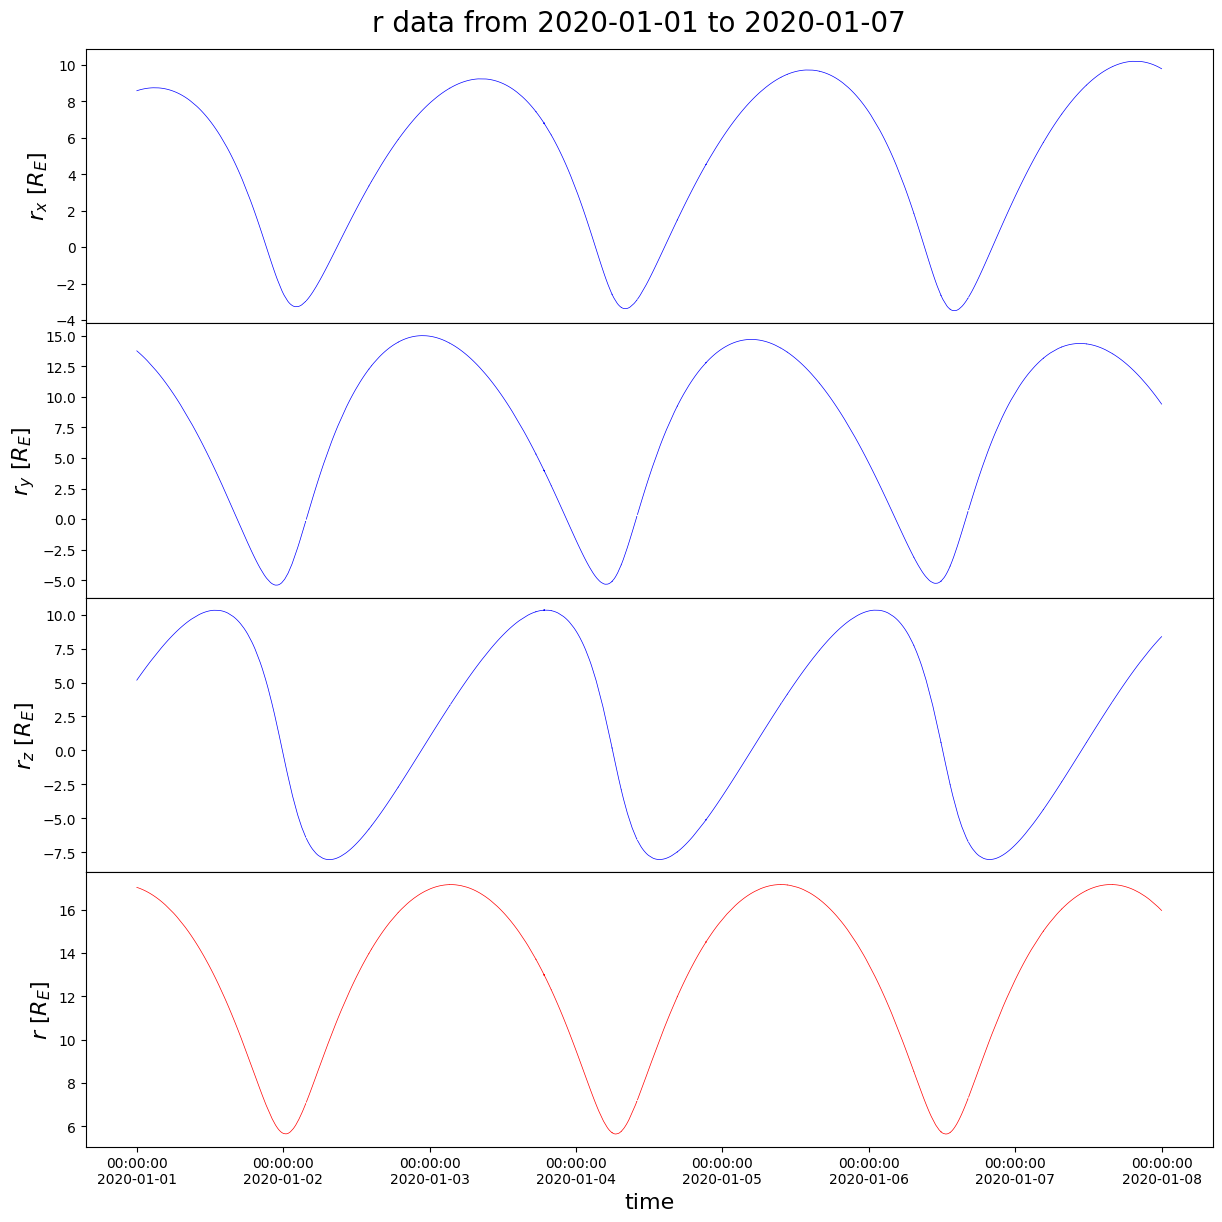

In [18]:
fig, axs = plt.subplots(4,  # 4 plots
                        figsize=(12,12), 
                        sharex=True, # share same x-range
                        sharey=False, # don't share same y-range
                        gridspec_kw={'hspace': 0})
fig.suptitle(f'r data from {start_date_str} to {end_date_str}', fontsize=20)

# Adjust the layout so that labels/titles don't overlap
plt.tight_layout()

for _, segment in df_fgm.groupby('segment'):
    # Plot r_x, r_y, and r_z against epoch on different axes
    axs[0].plot(segment['t'], segment['r_x']/R_E, c='b', lw=0.5)
    axs[1].plot(segment['t'], segment['r_y']/R_E, c='b', lw=0.5)
    axs[2].plot(segment['t'], segment['r_z']/R_E, c='b', lw=0.5)
    axs[3].plot(segment['t'], segment['r_mag']/R_E, c='r', lw=0.5)

# Add labels and title
plt.xlabel(r'time', fontsize=16) # or axs[2].set_xlabel

# Format the x-axis to display full dates and times with more detail
# "Hour:Minute:Second // Year-Month-Day"
date_format = mdates.DateFormatter('%H:%M:%S\n%Y-%m-%d')
axs[2].xaxis.set_major_formatter(date_format)

axs[0].set_ylabel(r'$r_x$ [$R_E$]', fontsize=16)
axs[1].set_ylabel(r'$r_y$ [$R_E$]', fontsize=16)
axs[2].set_ylabel(r'$r_z$ [$R_E$]', fontsize=16)
axs[3].set_ylabel(r'$r$ [$R_E$]', fontsize=16);

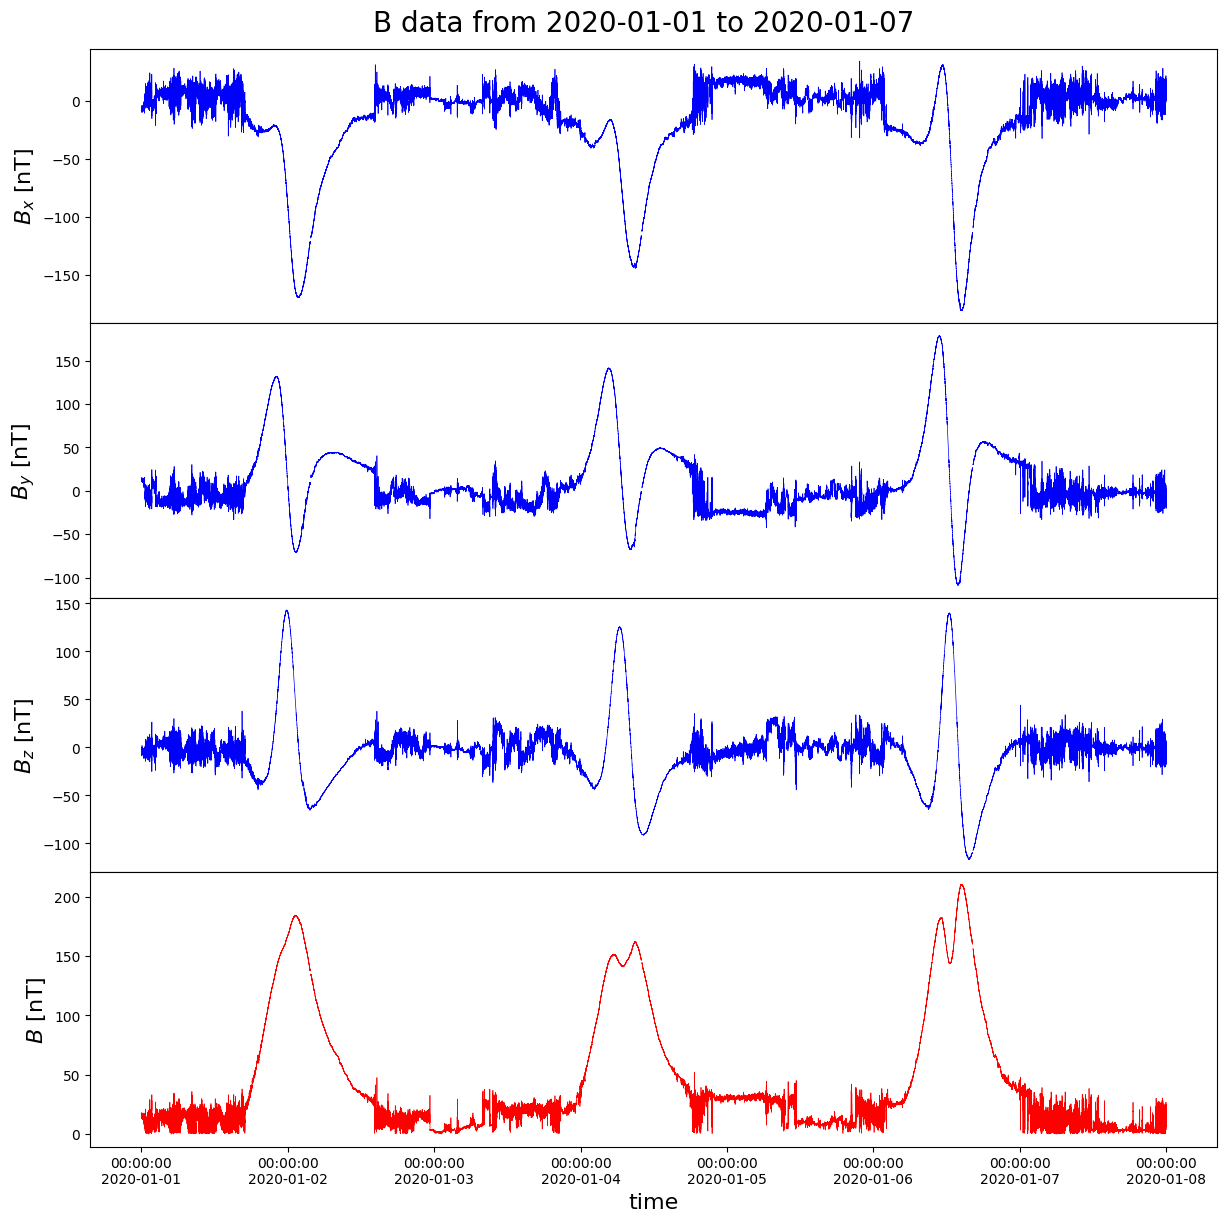

In [19]:
fig, axs = plt.subplots(4,  # 4 plots
                        figsize=(12,12), 
                        sharex=True, # share same x-range
                        sharey=False, # don't share same y-range
                        gridspec_kw={'hspace': 0})

fig.suptitle(f'B data from {start_date_str} to {end_date_str}', fontsize=20)

# Adjust the layout so that labels/titles don't overlap
plt.tight_layout()

for _, segment in df_fgm.groupby('segment'):
   # Plot B_x, B_y, and B_z against epoch on different axes
    axs[0].plot(segment['t'], segment['B_x'], c='b', lw=0.5)
    axs[1].plot(segment['t'], segment['B_y'], c='b', lw=0.5)
    axs[2].plot(segment['t'], segment['B_z'], c='b', lw=0.5)
    axs[3].plot(segment['t'], segment['B_mag'], c='r', lw=0.5)

# Add labels and title
plt.xlabel(r'time', fontsize=16) # or axs[2].set_xlabel

# Format the x-axis to display full dates and times with more detail
# "Hour:Minute:Second // Year-Month-Day"
date_format = mdates.DateFormatter('%H:%M:%S\n%Y-%m-%d')
axs[2].xaxis.set_major_formatter(date_format)

axs[0].set_ylabel(r'$B_x$ [nT]', fontsize=16)
axs[1].set_ylabel(r'$B_y$ [nT]', fontsize=16)
axs[2].set_ylabel(r'$B_z$ [nT]', fontsize=16)
axs[3].set_ylabel(r'$B$ [nT]', fontsize=16);

#plt.savefig(f'{data_name} data on {data_date}.png',bbox_inches='tight')

## Plotting Orbit

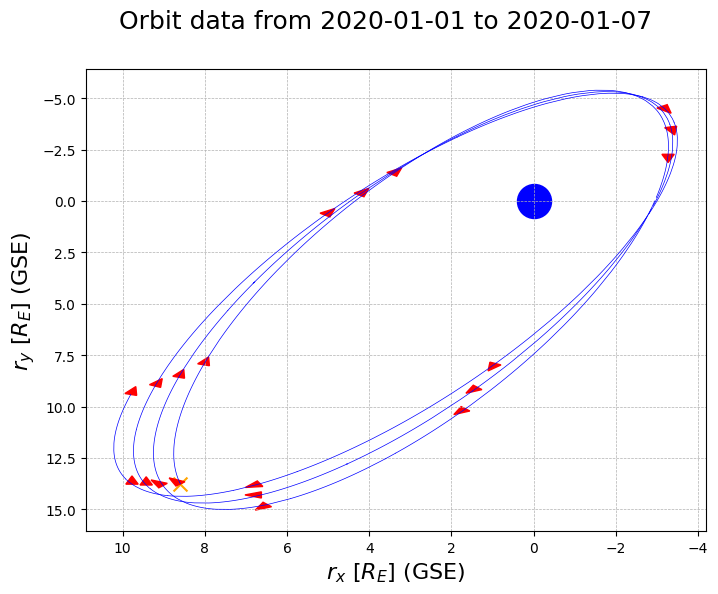

In [21]:
fig, ax = plt.subplots(figsize=(8,6))
fig.suptitle(f'Orbit data from {start_date_str} to {end_date_str}', fontsize=18)

plt.grid(linestyle='--', lw=0.5)

# Scaled to Earth radius
x0 = df_fgm['r_x'][0]/R_E
y0 = df_fgm['r_y'][0]/R_E

# Add small cross at the start point
ax.scatter(x0, y0, color='orange', marker='x', s=100)

# Add Earth
plt.scatter(0, 0, color='blue', marker='o', s=600)

for _, segment in df_fgm.groupby('segment'):
    # Plot ry against rx to see orbit in x-y plane
    ax.plot(segment['r_x']/R_E, segment['r_y']/R_E, c='b', lw=0.5)

# Add arrows to indicate direction
for i in np.linspace(50, len(df_fgm['r_x']) - 2, 20):
    i=int(i)
    xi  = df_fgm['r_x'][i]/R_E   ; yi  = df_fgm['r_y'][i]/R_E
    xi1 = df_fgm['r_x'][i+1]/R_E ; yi1 = df_fgm['r_y'][i+1]/R_E
    
    ax.arrow(xi, yi, xi1 - xi, yi1 - yi,
         head_width=.3, head_length=.4, fc='red', ec='red')

# Add labels and title
plt.xlabel(r'$r_x$ [$R_E$] (GSE)', fontsize=16)
plt.gca().invert_xaxis()

plt.ylabel(r'$r_y$ [$R_E$] (GSE)', fontsize=16)
plt.gca().invert_yaxis()

#plt.savefig(f'{data_name} data on {data_date}.png',bbox_inches='tight')

In [115]:
def shue(theta, r0, alpha):

    # Shue model equation for the boundary
    r_theta = r0 * (2 / (1 + np.cos(theta)))**alpha

    x, y = polar_to_cart(r_theta, theta)
    return x, y

def jelinek(theta, r0, epsilon):

    # Jelinek bow shock equation
    r_theta = r0 * (1 + epsilon / (1 + np.cos(theta)))

    x, y = polar_to_cart(r_theta, theta)
    return x, y

def polar_to_cart(r_theta, theta):

    # Convert to Cartesian coordinates
    x = r_theta * np.cos(theta)
    y = r_theta * np.sin(theta)

    return x, y

In [117]:
# Shue model parameters (for quiet solar wind)
r0 = 10.22  # standoff distance
alpha = 0.58

# Jelinek Bow Shock parameters (for quiet solar wind)
r0_bs = 10.22  # standoff distance
epsilon = 0.81  # curvature parameter

# Generate theta values (-pi/2 to pi/2 for dayside)
theta = np.linspace(-np.pi/2, np.pi/2, 100)

x_mp, y_mp = shue(theta, r0, alpha)
x_bs, y_bs = jelinek(theta, r0_bs, epsilon)

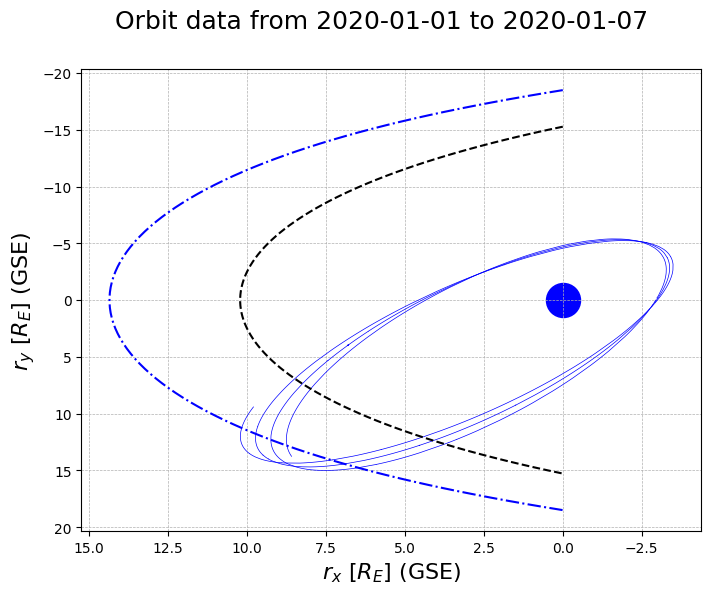

In [121]:
fig, ax = plt.subplots(figsize=(8,6))
fig.suptitle(f'Orbit data from {start_date_str} to {end_date_str}', fontsize=18)

plt.grid(linestyle='--', lw=0.5)

# Scaled to Earth radius
x0 = df_fgm['r_x'][0]/R_E
y0 = df_fgm['r_y'][0]/R_E

# Add Earth
plt.scatter(0, 0, color='blue', marker='o', s=600)

for _, segment in df_fgm.groupby('segment'):
    # Plot ry against rx to see orbit in x-y plane
    ax.plot(segment['r_x']/R_E, segment['r_y']/R_E, c='b', lw=0.5)

# Shue model boundary plot    
plt.plot(x_mp, y_mp, label='Shue MP Boundary', linestyle='--', color='black')

# Jelinek bow shock boundary
plt.plot(x_bs, y_bs, label='Jelinek Bow Shock Boundary', linestyle='-.', color='blue')

# Add labels and title
plt.xlabel(r'$r_x$ [$R_E$] (GSE)', fontsize=16)
plt.gca().invert_xaxis()

plt.ylabel(r'$r_y$ [$R_E$] (GSE)', fontsize=16)
plt.gca().invert_yaxis()

#plt.savefig(f'{data_name} data on {data_date}.png',bbox_inches='tight')

## Heat Map

In [51]:
# Scaled to Earth radius
x = df_fgm['r_x']/R_E
y = df_fgm['r_y']/R_E
z = df_fgm['r_z']/R_E

In [52]:
def plot_heat_map(xs,ys,zs,z_limits=None,bin_size=1,weight=False):
    """
    Procedure to plot a heat map of the orbit of the satellite in a 2D plane, (x-y).
    Arguments can be adjusted for the pixel size and whether to constrain when close to z=0 or not.

    Parameters
    ----------
    xs : pandas.Series
        x-coordinates of the satellite's orbit
        
    ys : pandas.Series
        y-coordinates of the satellite's orbit
        
    zs : pandas.Series
        z-coordinates of the satellite's orbit
        
    z_limits : tuples of 2 values : optional :
        Lower and upper limit for the values for the satellite in the z-plane.
        By default is None, (takes all values in z-plane).
        
    bin-size : int : optional
        Size of the pixels/bins for the heat map.
        By default is 1 (RE).

    weight : Boolean : optional
        Whether to weigh the histogram to display the legend in number of data points (default/False),
        or to weigh and display in minutes (True).

    Returns
    -------
        None : procedure just plots a figure.
    """
    fig, ax = plt.subplots(figsize=(8,6))

    x_name, y_name, z_name = xs.name, ys.name, zs.name

    # Calculate the number of bins based on the range of data and the bin size
    x_min, x_max = np.floor(xs.min()), np.ceil(xs.max())
    y_min, y_max = np.floor(ys.min()), np.ceil(ys.max())
    
    # Create bins starting from 0, with bin edges aligned to (0, 0)
    x_bins = np.arange(x_min, x_max + bin_size, bin_size) 
    y_bins = np.arange(y_min, y_max + bin_size, bin_size)

    # If no limits are passed in for z, use full data range
    if z_limits is None:
        z_min, z_max = np.floor(zs.min()), np.ceil(zs.max())
    else:
        z_min, z_max = z_limits[0], z_limits[1]
    mask = (zs >= z_min) & (zs <= z_max)

    # Create weights to display color bar
    c_label = "Number of Points"
    weights = np.ones_like(xs[mask])
     # Weighs the density values to display in minutes, assuming data 200ms apart
    if weight:
        weights = weights / 3000
        c_label = "Minutes"
    
    # Create the 2D histogram (heatmap)
    plt.hist2d(xs[mask], ys[mask], bins=[x_bins, y_bins], weights=weights, cmap='hot')
    plt.colorbar(label=c_label)
    
    # Add Earth
    plt.scatter(0, 0, color='blue', marker='o', s=600)
    
    # Set the x and y ticks to every 1 unit
    plt.xticks(np.arange(x_min, x_max + 1, 1))
    plt.yticks(np.arange(y_min, y_max + 1, 1))
    
    fig.suptitle(f'Orbit data from {start_date_str} to {end_date_str}\n where {z_min}$R_E$ $\leq${z_name[-1]}$\leq${z_max} $R_E$', fontsize=18)
    
    # Add labels and title
    plt.xlabel(f'${x_name[-1]}$ [$R_E$] (GSE)', fontsize=16)
    if x_name == "r_x" or x_name == "r_y":
        plt.gca().invert_xaxis()
    
    plt.ylabel(f'${y_name[-1]}$ [$R_E$] (GSE)', fontsize=16)
    if y_name == "r_x" or y_name == "r_y":
        plt.gca().invert_yaxis()

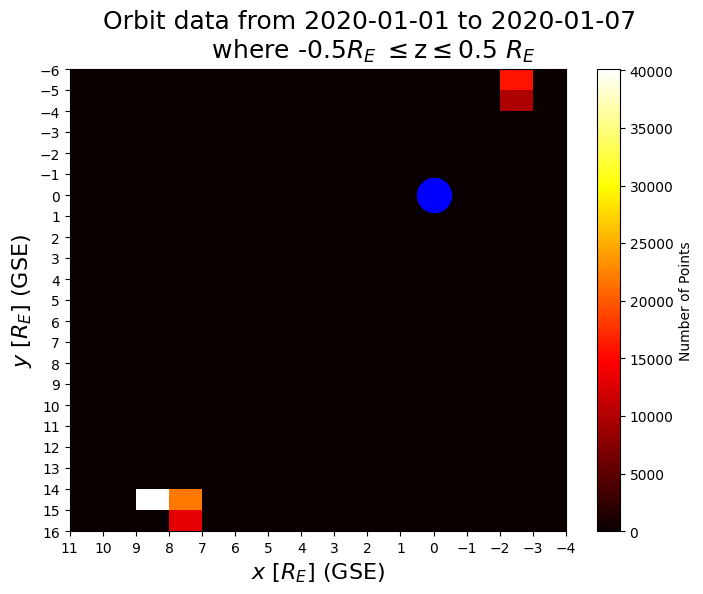

In [53]:
plot_heat_map(x,y,z,z_limits=(-0.5,0.5),bin_size=1,weight=False)